In [11]:
!pip install matplotlib opencv-python diffusers transformers scipy accelerate optimum
# !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tira_utils import get_input_directory_and_output_directory, normalize_run
import pyterrier as pt
import pandas as pd
import os
import json
from tqdm import tqdm
from glob import glob
from pathlib import Path
from collections import Counter
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from PIL import Image
from transformers import pipeline

Start PyTerrier with version=5.7, helper_version=0.0.7, no_download=True


PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.
/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from preselection import retrieve

directory
I will use a small hardcoded example located in /workspace/dataset22/.
The output directory is /tmp/
index exists


In [3]:
def load_queries():
    file_name = 'dataset22/topics.xml'
    
    if not os.path.exists(file_name):
        raise ValueError(f'Could not find the file "{file_name}". Got: {glob(input_directory + "/*")}')
    
    topics = pd.read_xml(file_name)
    
    ret = pd.DataFrame()
    # https://github.com/terrier-org/pyterrier/issues/62\n",
    ret['query'] = topics['title'].apply(lambda i: "".join([x if x.isalnum() else " " for x in i]))
    ret['qid'] = topics['number']
    return ret

In [4]:
classifier = pipeline("zero-shot-classification", model='facebook/bart-large-mnli', accelerator="bettertransformer", device=0)

input_directory = '/workspace/dataset22/'

In [5]:
# load image text
# We use some very baseline method to get a textual representation: we just use the text of the pages that contain the image.
def load_image_text(image_id):
    ret = ''
    for txt_file in glob(input_directory +'/images/' + image_id[:3] + '/' + image_id + '/*/*/*/text.txt'):
        ret += '\n\n' + open(txt_file).read()
    return ret.strip()

def determine_stance(text, query):
    labels = ["contra "+ query, "pro "+ query, "neutral "+ query]
    result = classifier(text, labels)
    # sorts the labels starting with the most likely
    if result["labels"][0].startswith("contra"):
        return "contra", result["scores"][0]
    elif result["labels"][0].startswith("pro"):
        return "pro", result["scores"][0]
    else: 
        return "neutral", result["scores"][0]
    

def detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_ids, query, x):
    # get image ids from preranking
    # get image texts based on preranking 
    pro_imgs = {}
    contra_imgs = {}
    pro_ids = []
    contra_ids = []
    
    for image_id in image_ids:
        text = load_image_text(image_id)
        # deploy model
        stance, score = determine_stance(text, query)
        # print(image_id, stance, score)
        # separate pro and con texts; sort out neutral texts
        if stance == "pro":
            pro_imgs[image_id] = score
        elif stance == "contra": 
            contra_imgs[image_id] = score
            
    # sort according to scores
    sorted_pro = dict(sorted(pro_imgs.items(), key=lambda x:x[1], reverse=True))
    sorted_contra = dict(sorted(contra_imgs.items(), key=lambda x:x[1], reverse=True))
    # return best x results for each side
    i = 0
    for key in sorted_pro:
        if i < len(sorted_pro.keys()) and i < x:
            pro_ids.append(key)
        else: 
            break
        i += 1
    i = 0
    for key in sorted_contra:
        if i < len(sorted_contra.keys()) and i < x:
            contra_ids.append(key)
        else: 
            break
        i += 1
    return pro_ids, contra_ids, sorted_pro, sorted_contra
# not sorted right

In [6]:
def load_image_paths(image_ids):
    image_paths = []
    
    for image_id in image_ids:
        image_paths.append('dataset22/images/' + image_id[:3] + '/' + image_id + '/image.webp')
        
    return image_paths

In [7]:
def load_image_generator():
    with open('token.txt') as ifp:
        access_token = ifp.readline()
        # print('Read a token of length {}'.format( len(access_token) ))
    
    model_id = "CompVis/stable-diffusion-v1-4"
    device = "cuda"
    
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16", use_auth_token=access_token, device_map="auto", cache_dir="stable_diffusion_cache")
    pipe = pipe.to(device)
    
    return pipe
    
def generate_image(pipe, prompt, isrealistic, image_name=None, guidance_scale=20, inference_steps=50):
    if isrealistic:
        final_prompt = "a photograph about the topic: " + prompt
    else:
        final_prompt = "an image in comic style about the topic: " + prompt
    
    print(final_prompt)
    
    image = None
    
    while image == None or not image.getbbox():
        image = pipe(final_prompt, guidance_scale=guidance_scale, num_inference_steps=inference_steps).images[0]
        print(not image.getbbox())

    if image_name != None:
        image.save("image_results/" + image_name + ".png")
    else:
        return image
    
def show_image(image_name):
    image = Image.open("image_results/" + image_name + ".png")
    image.show()

In [8]:
def flann_index_kdtree_matcher(image1, image2):
    MIN_MATCH_COUNT = 10
    
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1_gray, None)
    kp2, des2 = sift.detectAndCompute(image2_gray, None)
    
    if des1 is None or des2 is None:
        return [], 0
            
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    global good
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    
    if len(good) == 0:
        return [], 0
    
    most_common_keypoint_matches = Counter(x.trainIdx for x in good).most_common(1)[0]
    
    # single keypoint check for to many matches
    if most_common_keypoint_matches[1] > 10:
        return [], 0
            
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        
        if M is None:
            print("empty Homography on image")
            return [], 0
        
        matchesMask = mask.ravel().tolist()
        
        h,w, _ = image1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        image2 = cv.polylines(image2,[np.int32(dst)],True,255,3, cv.LINE_AA)
             
    else:
        # print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=cv.DrawMatchesFlags_DEFAULT)
    
    img_matches = np.empty((max(image1.shape[0], image2.shape[0]), image1.shape[1]+image2.shape[1], 3), dtype=np.uint8)
    # img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, **draw_params)
    
    # plt.imshow(img3, ), plt.show()
    
    return img3, len(good)

In [22]:
def sort_images(images, dataframe):
    sorted_images = []
    
    for i in range(len(images)):
        image_id = dataframe["image_id"][i]
        sorted_images.append(images[image_id])
    
    return sorted_images


def rank_images(images, image_name):
    print("image_results/" + image_name)
    topic_img = cv.cvtColor(cv.imread("image_results/" + image_name), cv.COLOR_BGR2RGB)
    image_ids = []
    match_numbers = []
    img_num = 0

    for image in images:
        # print(img_num)
    
        if image.size <= 100000000:
            img, good_matches = flann_index_kdtree_matcher(topic_img, image.copy())
        
            image_ids.append(img_num)
            match_numbers.append(good_matches)
    
        img_num += 1

    image_id_and_match_num_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
    sorted_image_id_and_match_num_dataframe = image_id_and_match_num_dataframe.sort_values(by=['match_num'], ascending=False).reset_index(drop=True)
    
    return sort_images(images, sorted_image_id_and_match_num_dataframe), sorted_image_id_and_match_num_dataframe


def update_image_id_and_match_num_dataframe(image_id_and_match_num_dataframe, curr_image_id_and_match_num_dataframe):
    for i in range(len(image_id_and_match_num_dataframe)):
        image_id = image_id_and_match_num_dataframe.iloc[i]["image_id"]
        
        for j in range(len(curr_image_id_and_match_num_dataframe)): 
            if image_id == curr_image_id_and_match_num_dataframe.iloc[j]["image_id"]:
                image_id_and_match_num_dataframe.iloc[i]["match_num"] += curr_image_id_and_match_num_dataframe.iloc[j]["match_num"]
        
    return image_id_and_match_num_dataframe


def combined_image_ranking(images, generated_image_names):
    image_id_and_match_num_dataframe = pd.DataFrame()
    
    for generated_image_name in generated_image_names:
        generated_image = cv.cvtColor(cv.imread("image_results/" + generated_image_name), cv.COLOR_BGR2RGB)
        image_ids = []
        match_numbers = []
        img_num = 0

        for image in images:
            if image.size <= 100000000:
                img, good_matches = flann_index_kdtree_matcher(generated_image, image.copy())
        
                image_ids.append(img_num)
                match_numbers.append(good_matches)
    
            img_num += 1
        
        if image_id_and_match_num_dataframe.empty:
            image_id_and_match_num_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
        else:
            curr_image_id_and_match_num_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
            image_id_and_match_num_dataframe = update_image_id_and_match_num_dataframe(image_id_and_match_num_dataframe, curr_image_id_and_match_num_dataframe)
    
    sorted_image_id_and_match_num_dataframe = image_id_and_match_num_dataframe.sort_values(by=['match_num'], ascending=False).reset_index(drop=True)
    
    return sort_images(images, sorted_image_id_and_match_num_dataframe), sorted_image_id_and_match_num_dataframe
    

In [23]:
def show_multiple_images(image_list, row_count, col_count, save_image_name=None):
    for i in range(0, len(image_list), row_count*col_count):
        fig = plt.figure(figsize=(20, 20), dpi=80)
    
    for j in range(0, row_count*col_count):
        fig.add_subplot(row_count, col_count, j+1)
        plt.imshow(image_list[i+j])
        
    if save_image_name != None:
        save_path = "image_results/" + save_image_name
        plt.savefig(save_path)
        
    plt.show()

In [94]:
def create_submission_format_with_list(preselection_data, image_ids, stance_string, image_num=10):
    submission_format = ""
    rank = 1
    
    for i in range(image_num):
        image_data = preselection_data.loc[preselection_data["docno"] == image_ids[i]]
        
        query_id = image_data["qid"].values[0]
        stance = stance_string
        image_id = image_data["docno"].values[0]
        image_rank = rank
        image_score = 50 - (rank-1)
        method = "-"
        
        submission_format += (str(query_id) + " " + str(stance) + " " + str(image_id) + " " + str(image_rank) + " " + str(image_score) + " " + str(method) + "\n")
        
        rank += 1
        
    print(submission_format)

def create_submission_format_with_dataframe(preselection_data, image_id_dataframe, stance_string, image_num=10):
    submission_format = ""
    rank = 1
    
    for i in range(image_num):
        image_data = preselection_data.iloc[image_id_dataframe["image_id"][i]]
        
        query_id = image_data.loc["qid"]
        stance = stance_string
        image_id = image_data.loc["docno"]
        image_rank = rank
        image_score = 50 - (rank-1)
        method = "-"
        
        submission_format += (str(query_id) + " " + str(stance) + " " + str(image_id) + " " + str(image_rank) + " " + str(image_score) + " " + str(method) + "\n")
        
        rank += 1
        
    print(submission_format)

In [92]:
def preselection_pipeline(query_with_qid, stance_string, pipe, max_image_num=10):
    local_query_with_qid = query_with_qid.copy()
    
    if stance_string == "pro":
        local_query_with_qid["query"].values[0] += " good"
    else:
        local_query_with_qid["query"].values[0] += " bad"
    
    preselection_data = retrieve(local_query_with_qid)
    image_docnos = preselection_data["docno"]
    print("preselection")

    create_submission_format_with_list(preselection_data, image_docnos, stance_string)
    print("submission")
    show_multiple_images(ranked_images, (max_image_num//2), 2)
    print("showed images")

def stance_pipeline(query_with_qid, stance_string, pipe, max_image_num=10):
    local_query_with_qid = query_with_qid.copy()
    
    if stance_string == "pro":
        local_query_with_qid["query"].values[0] += " good"
    else:
        local_query_with_qid["query"].values[0] += " bad"
    
    preselection_data = retrieve(local_query_with_qid)
    image_docnos = preselection_data["docno"]
    print("preselection")
    
    query = local_query_with_qid["query"].values[0]
    
    pro_ids, con_ids, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos, query, max_image_num)
    print("stance")
    
    image_ids = []
    if stance_string == "pro":
        image_ids = pro_ids
    else:
        image_ids = con_ids

    create_submission_format_with_list(preselection_data, image_ids, stance_string)
    print("submission")
    show_multiple_images(ranked_images, (max_image_num//2), 2)
    print("showed images")
    

def full_pipeline(query_with_qid, stance_string, pipe, max_image_num=10):
    local_query_with_qid = query_with_qid.copy()
    
    if stance_string == "pro":
        local_query_with_qid["query"].values[0] += " good"
    else:
        local_query_with_qid["query"].values[0] += " bad"
    
    preselection_data = retrieve(local_query_with_qid)
    image_docnos = preselection_data["docno"]
    print("preselection")
    
    query = local_query_with_qid["query"].values[0]
    
    pro_ids, con_ids, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos, query, max_image_num)
    print("stance")
    
    image_ids = []
    if stance_string == "pro":
        image_ids = pro_ids
    else:
        image_ids = con_ids
    
    image_paths = load_image_paths(image_ids)
    images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]
    print("get images")
    
    generate_image(pipe, query, True, "image_realistic")
    show_image("image_realistic")
    generate_image(pipe, query, False, "image_comic")
    show_image("image_comic")
    print("images generated")
    
    ranked_images, sorted_image_id_and_match_num_dataframe = combined_image_ranking(images, ["image_realistic.png", "image_comic.png"])
    print("ranking")

    create_submission_format_with_dataframe(preselection_data, sorted_image_id_and_match_num_dataframe, stance_string)
    print("submission")
    show_multiple_images(ranked_images, (max_image_num//2), 2)
    print("showed images")

In [ ]:
diff_pipe = load_image_generator()

In [34]:
queries = load_queries()
selected_query_with_qid = queries.iloc[[1]]
selected_query_with_qid

query  qid
1  Is vaping with e cigarettes safe     2

BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 13.26q/s]
/opt/conda/lib/python3.7/site-packages/transformers/pipelines/base.py:1048: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


preselection
stance
get images
a photograph about the topic: Is vaping with e cigarettes safe  good


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [01:27<00:00,  1.75s/it]


False


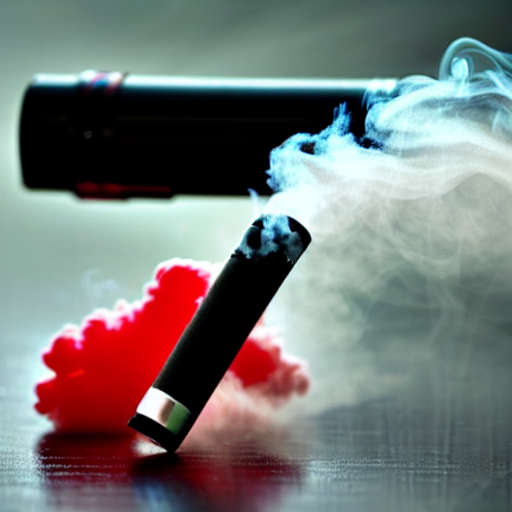

an image in comic style about the topic: Is vaping with e cigarettes safe  good


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [01:23<00:00,  1.68s/it]


False


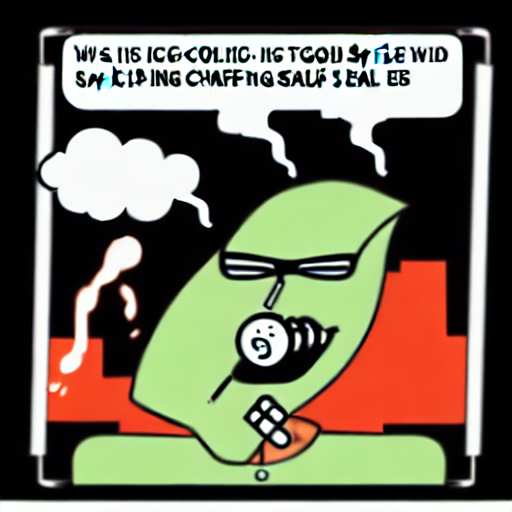

images generated
ranking
qid                                           2
docid                                      3749
docno                         I28834a0ecc4f5f06
rank                                          6
score                                 24.186597
query    Is vaping with e cigarettes safe  good
Name: 6, dtype: object
qid                                           2
docid                                      4357
docno                         I2ee2eb9b9b8d4236
rank                                          3
score                                 24.389105
query    Is vaping with e cigarettes safe  good
Name: 3, dtype: object
qid                                           2
docid                                      4468
docno                         I2fed43b070c21bfa
rank                                          7
score                                 24.186597
query    Is vaping with e cigarettes safe  good
Name: 7, dtype: object
qid                                       

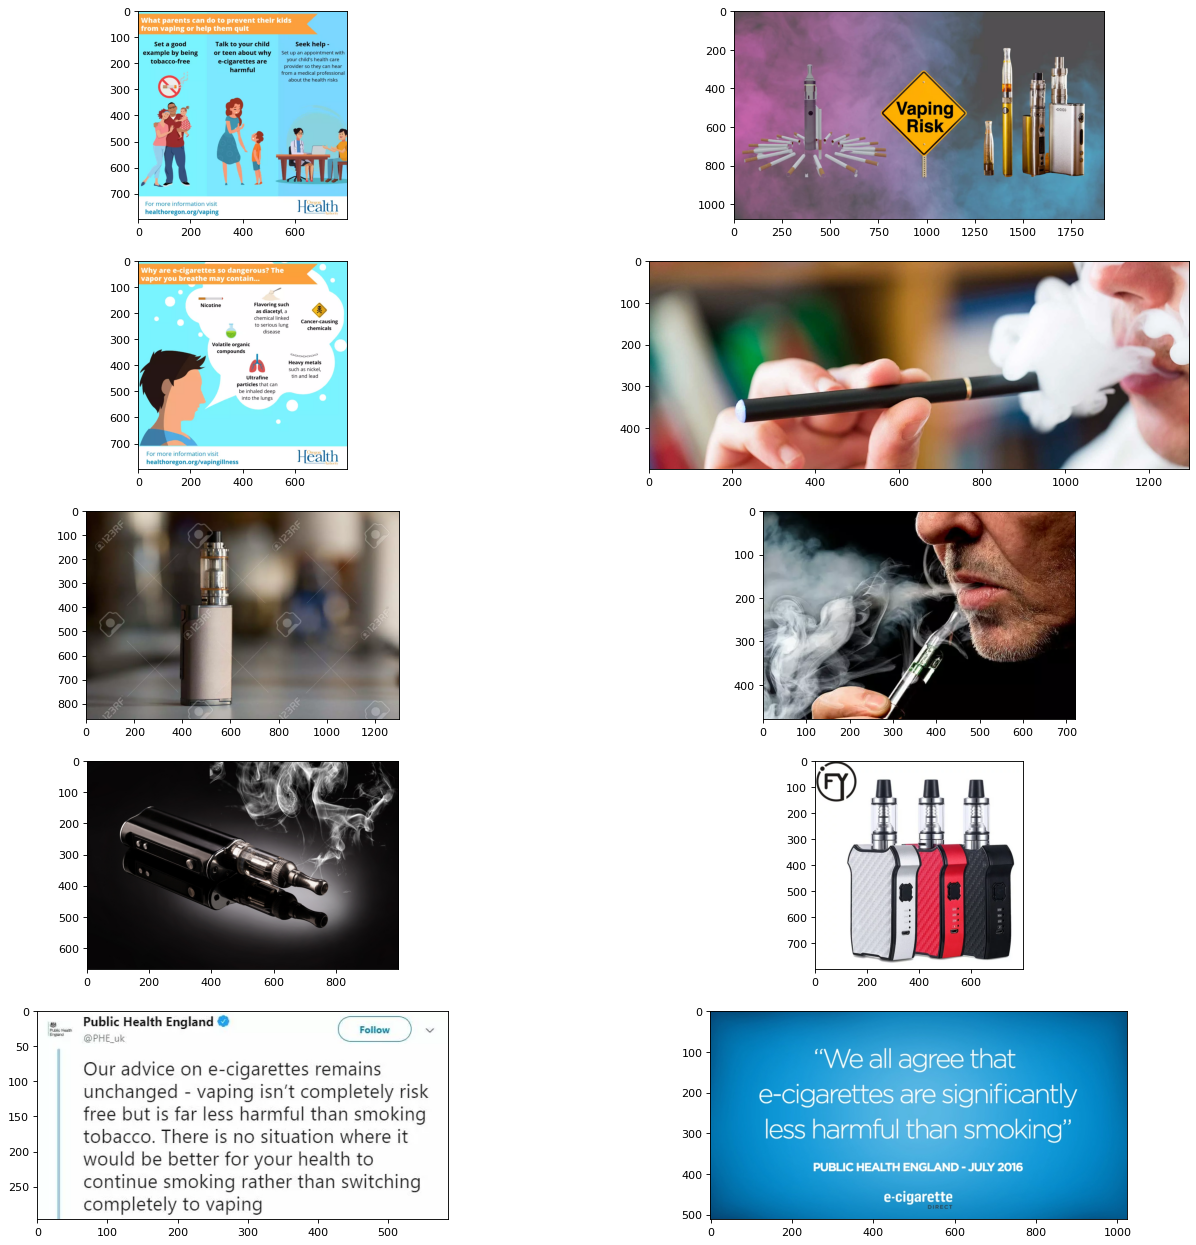

showed images


In [90]:
full_pipeline(selected_query_with_qid, "pro", diff_pipe, 10)

In [ ]:
full_pipeline(selected_query_with_qid, "con", diff_pipe, 10)

BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12.75q/s]
/opt/conda/lib/python3.7/site-packages/transformers/pipelines/base.py:1048: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


preselection
stance
   qid  docid              docno  rank     score  \
32   2   4655  I31cfdcceb48fd16b    32  23.43459   

                                     query  
32  Is vaping with e cigarettes safe  good  
   qid  docid              docno  rank     score  \
18   2   2607  I1b912dba7634fbd2    18  23.68173   

                                     query  
18  Is vaping with e cigarettes safe  good  
   qid  docid              docno  rank      score  \
19   2   2653  I1c0d7d7a324f890c    19  23.656686   

                                     query  
19  Is vaping with e cigarettes safe  good  
   qid  docid              docno  rank      score  \
33   2  16923  Ib6902c9f8328afc6    33  23.427675   

                                     query  
33  Is vaping with e cigarettes safe  good  
  qid  docid              docno  rank      score  \
9   2  20426  Idb33ee5b408af7c6     9  24.064909   

                                    query  
9  Is vaping with e cigarettes safe  good  
   

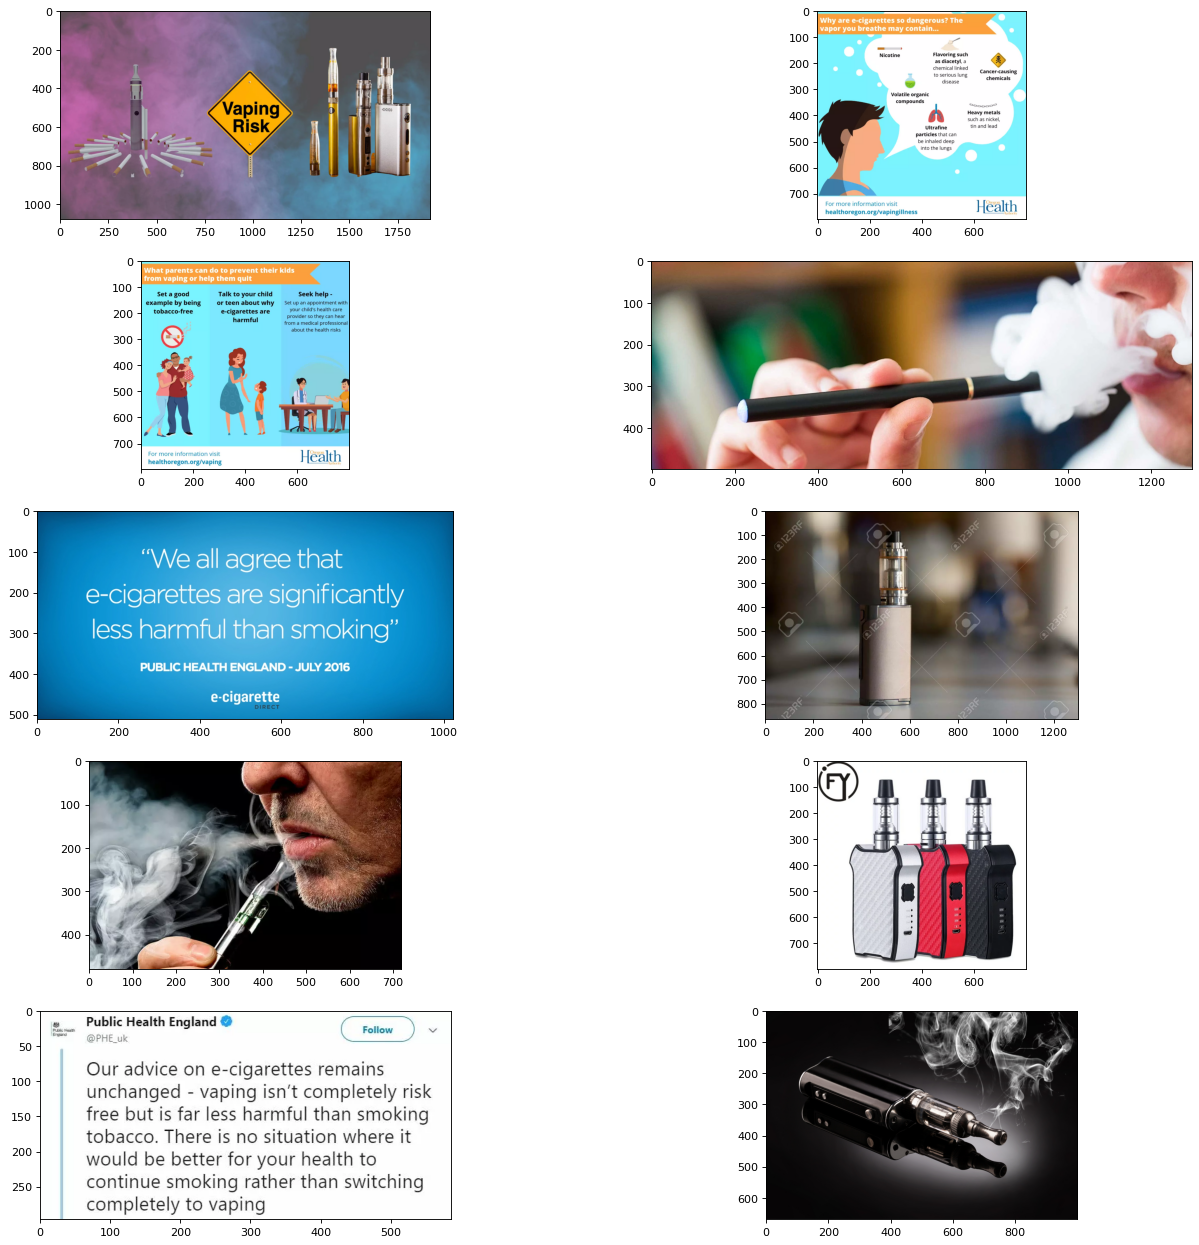

showed images


In [88]:
stance_pipeline(selected_query_with_qid, "pro", diff_pipe, 10)

BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15.81q/s]


preselection
  qid  docid              docno  rank      score  \
0   2  13256  I8e58116cb8e33efa     0  24.691843   

                                    query  
0  Is vaping with e cigarettes safe  good  
  qid  docid              docno  rank     score  \
1   2  20402  Idaf506598fca73d8     1  24.64358   

                                    query  
1  Is vaping with e cigarettes safe  good  
  qid  docid              docno  rank      score  \
2   2   1717  I12500f8647b45d46     2  24.471679   

                                    query  
2  Is vaping with e cigarettes safe  good  
  qid  docid              docno  rank      score  \
3   2   4357  I2ee2eb9b9b8d4236     3  24.389105   

                                    query  
3  Is vaping with e cigarettes safe  good  
  qid  docid              docno  rank      score  \
4   2  11374  I79f09baa3bda412b     4  24.260001   

                                    query  
4  Is vaping with e cigarettes safe  good  
  qid  docid            

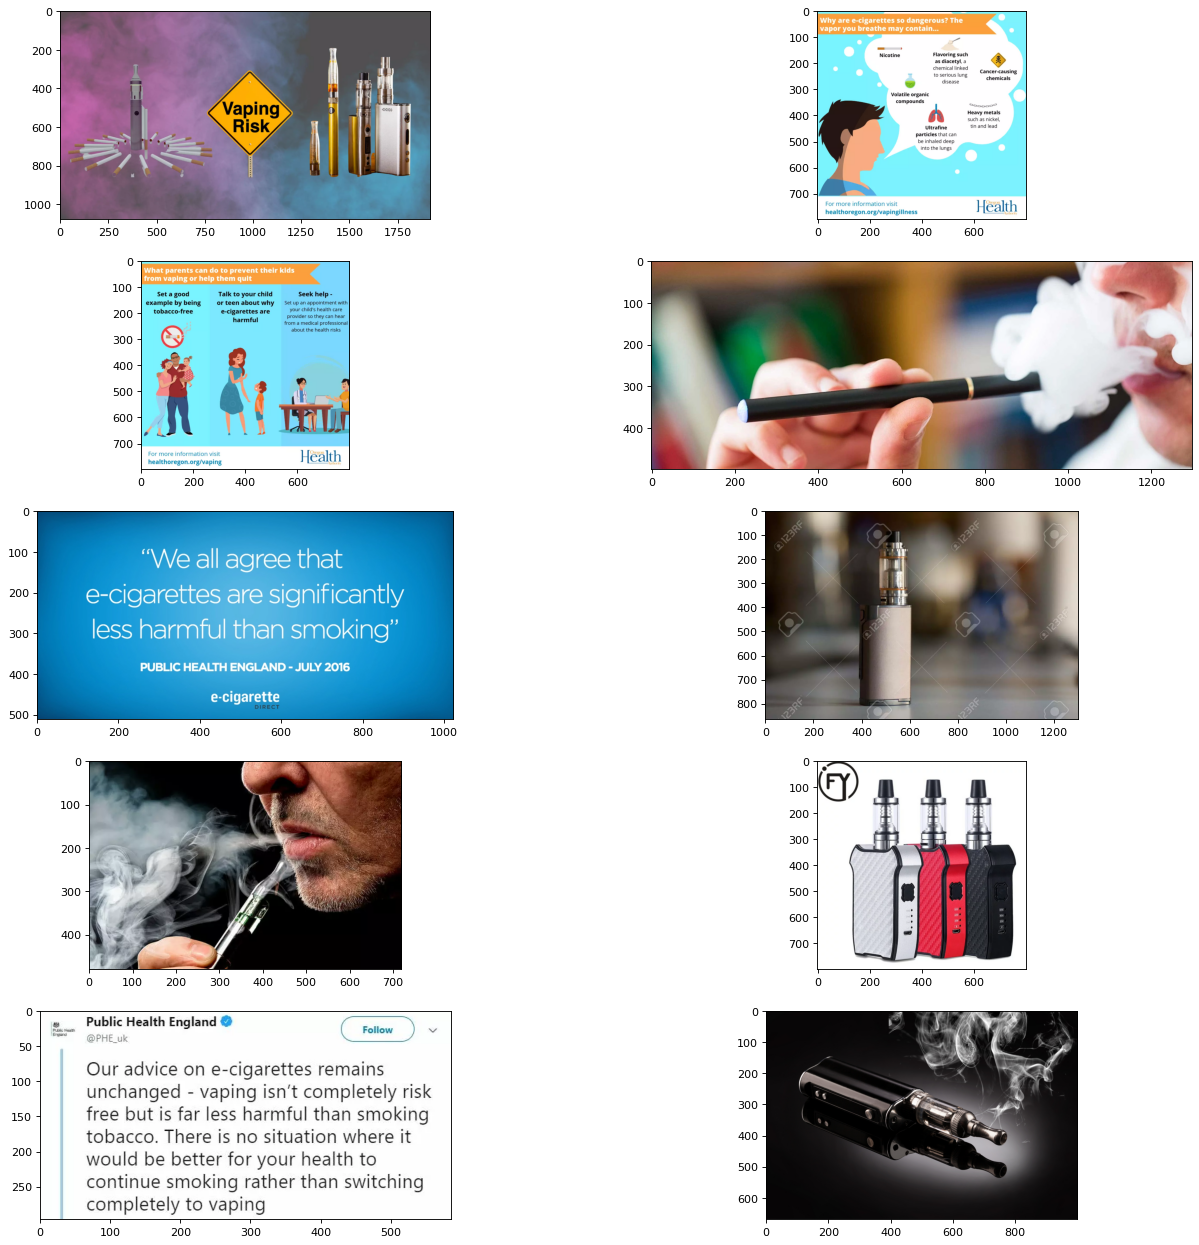

showed images


In [93]:
preselection_pipeline(selected_query_with_qid, "pro", diff_pipe, 10)

In [42]:
local_query_with_qid = selected_query_with_qid.copy()
stance_string = "pro"
max_image_num = 10
    
if stance_string == "pro":
    local_query_with_qid["query"].values[0] += " good"
else:
    local_query_with_qid["query"].values[0] += " bad"

preselection_data = retrieve(local_query_with_qid)
image_docnos = preselection_data["docno"]
print("preselection")

query = local_query_with_qid["query"].values[0]

pro_ids, con_ids, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos, query, max_image_num)
print("stance")

image_ids = []
if stance_string == "pro":
    image_ids = pro_ids
else:
    image_ids = con_ids

image_paths = load_image_paths(image_ids)
images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]
print("get images")

ranked_images, sorted_image_id_and_match_num_dataframe = combined_image_ranking(images, ["image_realistic.png", "image_comic.png"])

BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.51q/s]


preselection
stance
get images


In [63]:
image_ids

['I31cfdcceb48fd16b',
 'I1b912dba7634fbd2',
 'I1c0d7d7a324f890c',
 'Ib6902c9f8328afc6',
 'Idb33ee5b408af7c6',
 'Iba870b1b759eb895',
 'I4c1dd664acef7f44',
 'I57b3d99281c71a10',
 'I81ed31531ba25366',
 'I8e58116cb8e33efa']

In [48]:
test = sorted_image_id_and_match_num_dataframe["image_id"].values

In [67]:
preselection_data

qid  docid              docno  rank      score  \
0    2  13256  I8e58116cb8e33efa     0  24.691843   
1    2  20402  Idaf506598fca73d8     1  24.643580   
2    2   1717  I12500f8647b45d46     2  24.471679   
3    2   4357  I2ee2eb9b9b8d4236     3  24.389105   
4    2  11374  I79f09baa3bda412b     4  24.260001   
5    2  17707  Ibeee6836dd879c6b     5  24.258567   
6    2   3749  I28834a0ecc4f5f06     6  24.186597   
7    2   4468  I2fed43b070c21bfa     7  24.186597   
8    2  15234  Ia3e2bf061e9b8097     8  24.113852   
9    2  20426  Idb33ee5b408af7c6     9  24.064909   
10   2  16457  Ib149253fdf184507    10  24.023735   
11   2   3308  I23641f901191ef6d    11  23.957800   
12   2   2380  I194a0b327037f65b    12  23.926996   
13   2  12137  I81ed31531ba25366    13  23.911618   
14   2  18759  Ic9ecdb3b32edf1e9    14  23.822668   
15   2  10483  I7044d663fc53819c    15  23.801777   
16   2  16399  Ib0860408eadb9562    16  23.774326   
17   2  19666  Id38b2a4bbf074378    17  23.739266   
18   2   2607  I1b912dba7634fbd2    18  23.681730   
19   2   2653  I1c0d7d7a324f890c    19  23.656686   
20   2   4424  I2f879300cc39f9fc    20  23.650590   
21   2   5199  I37af3d9148afb4d5    21  23.637793   
22   2   7197  I4d03e6a01523a33e    22  23.623199   
23   2  15358  Ia51cfbd8878e4cb3    23  23.609185   
24   2  16592  Ib2c49cc10a21fd60    24  23.600105   
25   2   2352  I190795567f157766    25  23.576409   
26   2  21450  Ie6414254ef7378db    26  23.555695   
27   2   5190  I37842725ef1875df    27  23.532853   
28   2   7207  I4d1b4a094924fcf5    28  23.532853   
29   2  15395  Ia585d68d9f1912fe    29  23.495214   
30   2   1566  I10d92635503b5582    30  23.485454   
31   2  15469  Ia640a01ea49643d0    31  23.471432   
32   2   4655  I31cfdcceb48fd16b    32  23.434590   
33   2  16923  Ib6902c9f8328afc6    33  23.427675   
34   2   7114  I4c1dd664acef7f44    34  23.426293   
35   2   8176  I57b3d99281c71a10    35  23.426293   
36   2  12433  I8549cc501ca54dcb    36  23.405238   
37   2  23421  Ifb7295b4440040a4    37  23.405238   
38   2  18073  Ic2af5bb65342b1b1    38  23.396497   
39   2  19496  Id1cf099afa78b38a    39  23.383256   
40   2   5189  I37800ea4177d6365    40  23.378338   
41   2  13849  I94e0d91acb407990    41  23.361354   
42   2  17275  Iba4f71975297476e    42  23.361354   
43   2  17007  Ib7947dcd9a7c462d    43  23.347461   
44   2  13682  I93286a28ffcc054d    44  23.341469   
45   2   8661  I5c824a3e03138981    45  23.327566   
46   2  14308  I99aa53af4c5286ea    46  23.318381   
47   2  17299  Iba870b1b759eb895    47  23.277216   
48   2   5671  I3ce3976afbe6bea6    48  23.265564   
49   2   5732  I3d8d89b6e2bb2d33    49  23.248052   

                                     query  
0   Is vaping with e cigarettes safe  good  
1   Is vaping with e cigarettes safe  good  
2   Is vaping with e cigarettes safe  good  
3   Is vaping with e cigarettes safe  good  
4   Is vaping with e cigarettes safe  good  
5   Is vaping with e cigarettes safe  good  
6   Is vaping with e cigarettes safe  good  
7   Is vaping with e cigarettes safe  good  
8   Is vaping with e cigarettes safe  good  
9   Is vaping with e cigarettes safe  good  
10  Is vaping with e cigarettes safe  good  
11  Is vaping with e cigarettes safe  good  
12  Is vaping with e cigarettes safe  good  
13  Is vaping with e cigarettes safe  good  
14  Is vaping with e cigarettes safe  good  
15  Is vaping with e cigarettes safe  good  
16  Is vaping with e cigarettes safe  good  
17  Is vaping with e cigarettes safe  good  
18  Is vaping with e cigarettes safe  good  
19  Is vaping with e cigarettes safe  good  
20  Is vaping with e cigarettes safe  good  
21  Is vaping with e cigarettes safe  good  
22  Is vaping with e cigarettes safe  good  
23  Is vaping with e cigarettes safe  good  
24  Is vaping with e cigarettes safe  good  
25  Is vaping with e cigarettes safe  good  
26  Is vaping with e cigarettes safe  good  
27  Is vaping with e cigarettes safe  g

In [81]:
preselection_data.loc[preselection_data["docno"] == image_ids[0]]["qid"].values[0]

'2'